In [ ]:
import hydra
import torch
from torch.utils import data
from src.commons.constants import PROJECT_PATH
from omegaconf import DictConfig, OmegaConf

from src.data.process import DefaultTransform
from src.data.loader import BiTemporalDataset
from src.data.process import collate_align_prompt

def load_config():
    # Initialize the Hydra configuration
    hydra.initialize(config_path="../../configs", version_base=None)
    
    # Compose the configuration with the desired environment override
    cfg = hydra.compose(config_name="train", overrides=["experiment=mp_naive", "sam_type=small", "data=levir-cd"])
    
    return cfg

from hydra.core.global_hydra import GlobalHydra
GlobalHydra.instance().clear()
cfg = load_config()
print(OmegaConf.to_yaml(cfg))

In [5]:
module = hydra.utils.instantiate(cfg.model.instance)

In [6]:
params = {
    "prompt_type": "sample",
    "n_prompt": 1,
    #"n_shape": 20,
    "loc": "center",
    "batch_size": 2,
}
ds = BiTemporalDataset(
            name="levir-cd",
            dtype="train",
            transform=DefaultTransform(),
            params=OmegaConf.create(params),
        )

idx_sample = None
subset = ds
if idx_sample:
    subset = torch.utils.data.Subset(ds, [idx_sample-1, idx_sample])

dloader = data.DataLoader(
            subset,
            batch_size=params.get('batch_size'),
            shuffle=False,
            num_workers=0,
            collate_fn=collate_align_prompt
        )

In [7]:
len(subset)

445

In [8]:
for i, batch in enumerate(dloader):
    out = module._step(batch)
    print(out[0][1].sum())
    if i==0:break


/home/MDizier/data/dl/levir-cd/train/label/train_1.png
/home/MDizier/data/dl/levir-cd/train/label/train_2.png
tensor(-3.4009e+08, grad_fn=<SumBackward0>)


In [9]:
y = batch["label"].to(torch.float)
preds, ious  = module.model(batch, multimask_output=False)

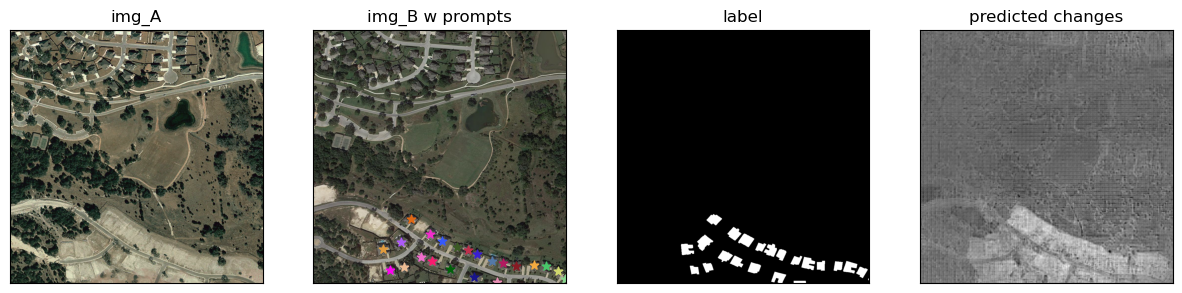

In [11]:
fig = show_prediction_sample((dict(pred=out[0])|dict(batch=batch)), idx=0)
fig

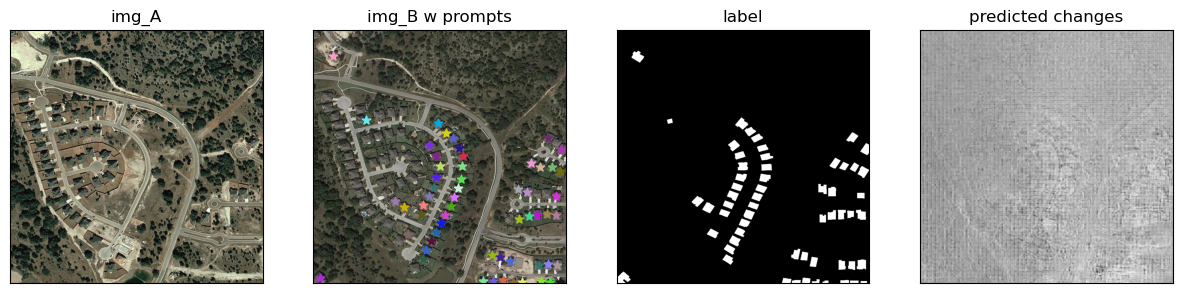

In [24]:
fig = show_prediction_sample((dict(pred=shift_range_values(out[0]))|dict(batch=batch)), idx=1)
fig

In [23]:
from src.commons.utils import shift_range_values
shift_range_values(out[0])

tensor([[[0.8236, 0.8236, 0.8237,  ..., 0.8264, 0.8339, 0.8339],
         [0.8236, 0.8236, 0.8237,  ..., 0.8264, 0.8339, 0.8339],
         [0.8263, 0.8263, 0.8260,  ..., 0.8278, 0.8346, 0.8346],
         ...,
         [0.8350, 0.8350, 0.8338,  ..., 0.8366, 0.8358, 0.8358],
         [0.8337, 0.8337, 0.8325,  ..., 0.8362, 0.8354, 0.8354],
         [0.8337, 0.8337, 0.8325,  ..., 0.8362, 0.8354, 0.8354]],

        [[0.4742, 0.4742, 0.4708,  ..., 0.4708, 0.4774, 0.4774],
         [0.4742, 0.4742, 0.4708,  ..., 0.4708, 0.4774, 0.4774],
         [0.4713, 0.4713, 0.4678,  ..., 0.4627, 0.4686, 0.4686],
         ...,
         [0.4253, 0.4253, 0.4196,  ..., 0.4337, 0.4297, 0.4297],
         [0.4243, 0.4243, 0.4184,  ..., 0.4351, 0.4308, 0.4308],
         [0.4243, 0.4243, 0.4184,  ..., 0.4351, 0.4308, 0.4308]]],
       grad_fn=<AddBackward0>)

<Axes: >

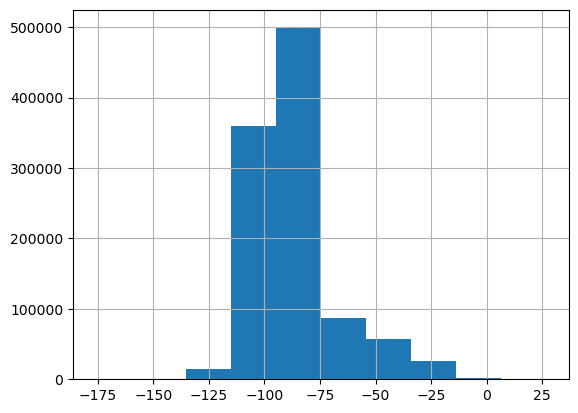

In [21]:
import pandas as pd
pd.Series(out[0][0].detach().flatten()).hist()

In [22]:
pd.Series(out[0][0].detach().flatten()).describe()

count    1.048576e+06
mean    -8.679656e+01
std      1.881201e+01
min     -1.760730e+02
25%     -9.773333e+01
50%     -9.139110e+01
75%     -8.222363e+01
max      2.695447e+01
dtype: float64

In [17]:
torch.nn.Sigmoid()(out[0][0])

tensor([[6.1166e-39, 6.1166e-39, 6.6224e-39,  ..., 3.9354e-38, 5.1378e-36,
         5.1378e-36],
        [6.1166e-39, 6.1166e-39, 6.6224e-39,  ..., 3.9354e-38, 5.1378e-36,
         5.1378e-36],
        [3.5468e-38, 3.5468e-38, 2.8888e-38,  ..., 9.5930e-38, 7.7502e-36,
         7.7502e-36],
        ...,
        [1.0429e-35, 1.0429e-35, 4.7857e-36,  ..., 2.9890e-35, 1.7589e-35,
         1.7589e-35],
        [4.4695e-36, 4.4695e-36, 2.0559e-36,  ..., 2.3173e-35, 1.3632e-35,
         1.3632e-35],
        [4.4695e-36, 4.4695e-36, 2.0559e-36,  ..., 2.3173e-35, 1.3632e-35,
         1.3632e-35]], grad_fn=<SigmoidBackward0>)

In [31]:
batch["label"].dtype

torch.float32

emb prompt element pos 1 nan

In [23]:
loss_func = torch.nn.BCEWithLogitsLoss()
preds_ = torch.sum(preds, dim=1)
loss = loss_func(preds_[1], y[1])
loss

tensor(nan, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [25]:
y[1].shape

torch.Size([1024, 1024])

In [28]:
p_ = preds.clone()
p_ = torch.nan_to_num(p_, nan=0.)

In [30]:
preds_ = torch.sum(p_, dim=1)
loss = loss_func(preds_[1], y[1])
loss

tensor(40.2587, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [17]:
preds[1].shape

torch.Size([101, 1024, 1024])

In [ ]:
preds[1]

In [70]:
batch["label"]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]])

In [52]:
out[1]

tensor(nan, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
out